# Predicting Re-hospitalization of Diabetic Patients

## Importing all libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from pyspark.sql import SparkSession
from pyspark.ml import feature
from pyspark.ml import regression
from pyspark.sql import functions as fn
from pyspark.sql.functions import countDistinct
from pyspark.sql import Row
from pyspark import sql
import seaborn as sns
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml import clustering
from pyspark.ml import classification
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns
import decimal
from pyspark.sql.types import StructType
from pyspark.sql.types import *
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import roc_curve, auc
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

## Initializing Spark Context

In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
# Downloading the csv file 
df_spark = spark.read.csv("diabetic_data.csv",header=True)

## Data Cleaning and Pre-processing

## Removal of columns

In [4]:
# Removing Weight, Payer Code and Medical speciality of the surgeon as they have 80-90% missing values
drop_list = ['weight', 'payer_code','medical_specialty','citoglipton','examide']
df_spark = df_spark.select([column for column in df_spark.columns if column not in drop_list])

## Removal of rows

In [5]:
# Removing rows from Race,Discharge Disposition ID,Admission Source ID, Admission type ID
df_spark = df_spark.filter(df_spark.race!='?')
df_spark = df_spark.filter(df_spark.diag_1!='?')
df_spark = df_spark.filter(df_spark.diag_2!='?')
df_spark = df_spark.filter(df_spark.diag_3!='?')
df_spark = df_spark.filter(df_spark.discharge_disposition_id.isin(['11' '18','19','20','25'])==False)
df_spark = df_spark.filter(df_spark.admission_source_id.isin(['9','17','20'])==False)
df_spark = df_spark.filter(df_spark.admission_type_id.isin(['5','6','8'])==False)

## Changing Data Types

In [6]:
# Changing Data type of patient nbr and encounter_id to int
df_spark = df_spark.withColumn("patient_nbr", df_spark["patient_nbr"].cast(IntegerType()))
df_spark = df_spark.withColumn("encounter_id", df_spark["encounter_id"].cast(IntegerType()))

In [7]:
# Changing Data type of admission_type_id,discharge_disposition_id and all numerical columns to float
df_spark_clean1 = df_spark.select("encounter_id","patient_nbr",*(fn.col(c).cast("float").alias(c) for c in df_spark.columns 
                                 if c in ('admission_source_id','admission_type_id','discharge_disposition_id','time_in_hospital',
                                         'num_procedures','num_lab_procedures','num_medications','number_outpatient','number_emergency',
                                        'number_inpatient','number_diagnoses' )))

## Joining two dataframes

In [8]:
# Merging df_spark_clean and df_spark to get the entire cleaned dataset
drop_list = ['admission_type_id','discharge_disposition_id',
             'admission_source_id','time_in_hospital','num_lab_procedures',
             'num_procedures','num_medications','number_outpatient','number_emergency',
             'number_inpatient','number_diagnoses','patient_nbr']
diabetic_data_clean2 = df_spark.select([column for column in df_spark.columns if column not in drop_list])

df_spark = df_spark_clean1.join(diabetic_data_clean2, 'encounter_id', 'inner')

In [9]:
# Creating a temp file to query in future
df_spark.createOrReplaceTempView("temp") 

## Exploratory Data Analysis and Data Manipulation

In [10]:
readmitted_count = df_spark.select('readmitted').groupBy('readmitted').count().show()
spark.sql("Select readmitted, count(readmitted),(count(readmitted)*100/(select count(readmitted) from temp)) as Percentage from temp group by readmitted").show()
# 11% of patients were readmitted within 30 days (<30)
# 35% of patients were readmitted after 30 days (>30)
# 54% of patients were never readmitted (NO)

+----------+-----+
|readmitted|count|
+----------+-----+
|       >30|30357|
|        NO|46654|
|       <30| 9850|
+----------+-----+

+----------+-----------------+------------------+
|readmitted|count(readmitted)|        Percentage|
+----------+-----------------+------------------+
|       >30|            30357| 34.94894141214124|
|        NO|            46654| 53.71110164515721|
|       <30|             9850|11.339956942701559|
+----------+-----------------+------------------+



Text(0,0.5,'Relative Frequency')

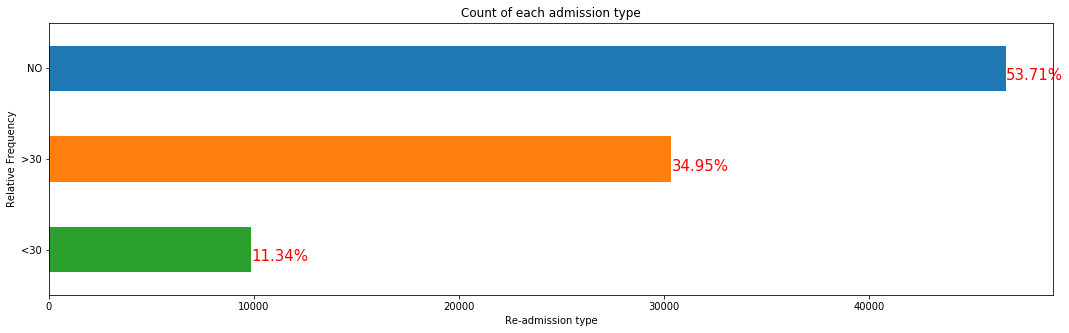

In [11]:
# The response variable 'readmitted' in the original dataset contains three categories.

a = df_spark.toPandas()
ax = a['readmitted'].value_counts().plot(kind='barh',figsize=(18,5),title="Count of each admission type")

totals = []
for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='red')
ax.invert_yaxis()
ax.set_xlabel("Re-admission type")
ax.set_ylabel("Relative Frequency")

In [12]:
# Recode the readmission variable to 1 and 0 to find out correlation with predictor variables
# '0' means no readmission
# '1' means readmission no matter how many days after being discharged

df_spark = df_spark.withColumn('readmitted',fn.when(df_spark["readmitted"] == 'NO', 0).otherwise(1))
df_spark.createOrReplaceTempView("temp2") 

# We are keeping >30 and <30 days of re-admission as 1 as our scope of the project is to predict whether a patient
# will be re-admitted again or not after being diagosed with diabetes.

                    num_lab_procedures  num_procedures  num_medications  \
num_lab_procedures            1.000000        0.034882         0.276721   
num_procedures                0.034882        1.000000         0.382727   
num_medications               0.276721        0.382727         1.000000   
number_outpatient             0.021679       -0.021872         0.042476   
number_emergency              0.010894       -0.037808         0.012790   
number_inpatient              0.043331       -0.071090         0.063656   
number_diagnoses              0.162271        0.051944         0.240013   
readmitted                    0.028129       -0.047420         0.042582   

                    number_outpatient  number_emergency  number_inpatient  \
num_lab_procedures           0.021679          0.010894          0.043331   
num_procedures              -0.021872         -0.037808         -0.071090   
num_medications              0.042476          0.012790          0.063656   
number_outpatien

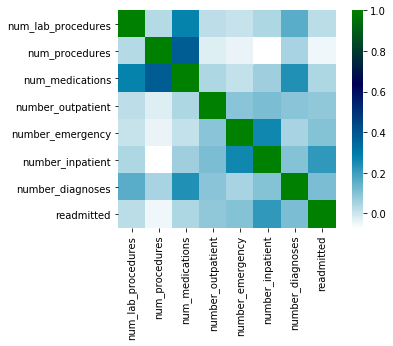

In [13]:
# Checking correlation among numerical variables and target variable readmitted
corr_matrix = df_spark.select('num_lab_procedures','num_procedures','num_medications','number_outpatient',
                              'number_emergency','number_inpatient','number_diagnoses','readmitted')

pd_corr = corr_matrix.toPandas()
print(pd_corr.corr())
sns.heatmap(pd_corr.corr(),square=True,cmap='ocean_r')

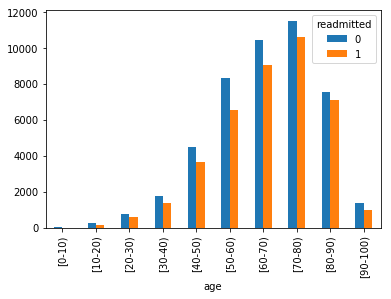

In [14]:
# Stacked Bar Graph with Age and Readmitted
df2 = df_spark.toPandas().groupby(['age', 'readmitted'])['age'].count().unstack('readmitted')
df2[[0,1]].plot(kind='bar', stacked=False)

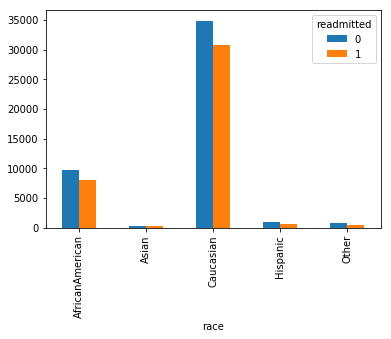

In [15]:
# Stacked Bar Graph with Race and Readmitted
df2 = df_spark.toPandas().groupby(['race', 'readmitted'])['race'].count().unstack('readmitted')
df2[[0,1]].plot(kind='bar', stacked=False)

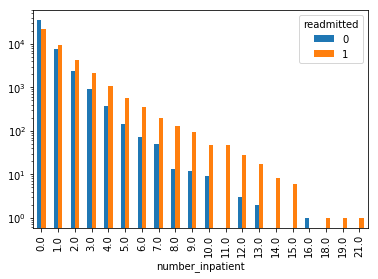

In [16]:
# Stacked Bar Graph with Inpatient and Readmitted
df2 = df_spark.toPandas().groupby(['number_inpatient', 'readmitted'])['number_inpatient'].count().unstack('readmitted')
df2[[0,1]].plot(kind='bar', stacked=False,logy=True)

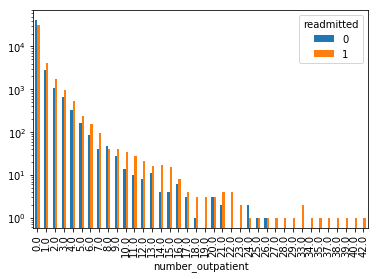

In [17]:
# Stacked Bar Graph with Outpatient and Readmitted
df2 = df_spark.toPandas().groupby(['number_outpatient', 'readmitted'])['number_outpatient'].count().unstack('readmitted')
df2[[0,1]].plot(kind='bar', stacked=False,logy=True)

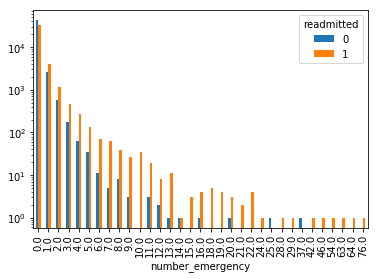

In [18]:
# Stacked Bar Graph with Emergency and Readmitted
df2 = df_spark.toPandas().groupby(['number_emergency', 'readmitted'])['number_emergency'].count().unstack('readmitted')
df2[[0,1]].plot(kind='bar', stacked=False,logy=True)

# Feature Engineering

In [19]:
## Creating new column total_visits = number_inpatient + number_outpatient
dfsum = fn.col('number_outpatient') + fn.col('number_inpatient')
df_spark = df_spark.withColumn('total_visits',dfsum)

## Creating Dummy variables for nominal categorical columns

In [20]:
# Creating dummy variables for admission_type_id
df_spark = df_spark.withColumn('admission_type_emergency',fn.when(fn.col('admission_type_id')==1,1).otherwise(0))
df_spark = df_spark.withColumn('admission_type_urgent',fn.when(fn.col('admission_type_id')==2,1).otherwise(0))
df_spark = df_spark.withColumn('admission_type_elective',fn.when(fn.col('admission_type_id')==3,1).otherwise(0))
df_spark = df_spark.withColumn('admission_type_trauma',fn.when(fn.col('admission_type_id')==7,1).otherwise(0))

#df_spark_final.select('admission_type_emergency','admission_type_urgent','admission_type_elective','admission_type_trauma').show(5)

In [21]:
# Creating dummy variables for discharge_disposition_id
df_spark = df_spark.withColumn('dd_home',fn.when(fn.col('discharge_disposition_id')==1,1).otherwise(0))
df_spark = df_spark.withColumn('dd_shortm_hos',fn.when(fn.col('discharge_disposition_id')==2,1).otherwise(0))
df_spark = df_spark.withColumn('dd_snf',fn.when(fn.col('discharge_disposition_id')==3,1).otherwise(0))
df_spark = df_spark.withColumn('dd_icf',fn.when(fn.col('discharge_disposition_id')==4,1).otherwise(0))
df_spark = df_spark.withColumn('dd_careInst',fn.when(fn.col('discharge_disposition_id')==5,1).otherwise(0))
df_spark = df_spark.withColumn('dd_hhs',fn.when(fn.col('discharge_disposition_id')==6,1).otherwise(0))
df_spark = df_spark.withColumn('dd_ama',fn.when(fn.col('discharge_disposition_id')==7,1).otherwise(0))
df_spark = df_spark.withColumn('dd_homeIvy',fn.when(fn.col('discharge_disposition_id')==8,1).otherwise(0))
df_spark = df_spark.withColumn('dd_admInp',fn.when(fn.col('discharge_disposition_id')==9,1).otherwise(0))
df_spark = df_spark.withColumn('dd_expired',fn.when(fn.col('discharge_disposition_id')==11,1).otherwise(0))
df_spark = df_spark.withColumn('dd_hospice',fn.when(fn.col('discharge_disposition_id')==13,1).otherwise(0))
df_spark = df_spark.withColumn('dd_medfac',fn.when(fn.col('discharge_disposition_id')==14,1).otherwise(0))
df_spark = df_spark.withColumn('dd_swingbed',fn.when(fn.col('discharge_disposition_id')==15,1).otherwise(0))
df_spark = df_spark.withColumn('dd_rehab',fn.when(fn.col('discharge_disposition_id')==22,1).otherwise(0))
df_spark = df_spark.withColumn('dd_long',fn.when(fn.col('discharge_disposition_id')==23,1).otherwise(0))
df_spark = df_spark.withColumn('dd_nursing',fn.when(fn.col('discharge_disposition_id')==24,1).otherwise(0))
df_spark = df_spark.withColumn('dd_federal',fn.when(fn.col('discharge_disposition_id')==27,1).otherwise(0))
df_spark = df_spark.withColumn('dd_psy',fn.when(fn.col('discharge_disposition_id')==28,1).otherwise(0))

In [22]:
# Creating dummy variables for admission_source_id
df_spark = df_spark.withColumn('admission_source_phyref',fn.when(fn.col('admission_source_id')==1,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_cliref',fn.when(fn.col('admission_source_id')==2,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_hmoref',fn.when(fn.col('admission_source_id')==3,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_hos',fn.when(fn.col('admission_source_id')==4,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_snf',fn.when(fn.col('admission_source_id')==5,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_hlthcare',fn.when(fn.col('admission_source_id')==6,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_emergency',fn.when(fn.col('admission_source_id')==7,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_court',fn.when(fn.col('admission_source_id')==8,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_critical',fn.when(fn.col('admission_source_id')==10,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_normdel',fn.when(fn.col('admission_source_id')==11,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_birth',fn.when(fn.col('admission_source_id')==14,1).otherwise(0))
df_spark = df_spark.withColumn('admission_source_surgery',fn.when(fn.col('admission_source_id')==25,1).otherwise(0))


In [23]:
# Creating dummy variables for race
df_spark = df_spark.withColumn('AfricanAmerican',fn.when(fn.col('race')=='AfricanAmerican',1).otherwise(0))
df_spark = df_spark.withColumn('Asian',fn.when(fn.col('race')=='Asian',1).otherwise(0))
df_spark = df_spark.withColumn('Caucasian',fn.when(fn.col('race')=='Caucasian',1).otherwise(0))
df_spark = df_spark.withColumn('Hispanic',fn.when(fn.col('race')=='Hispanic',1).otherwise(0))

# df_spark.select('AfricanAmerican','Asian','Caucasian','Hispanic','Other').show(5)

In [24]:
# Creating dummy variables for gender
df_spark = df_spark.withColumn('gender_male',fn.when(fn.col('gender')=='Male',1).otherwise(0))

In [25]:
# Grouped all the different types of diganosis based on their diag values specificed by the mapping document(ICD codes)
# Created dummy variables for each category

df_spark = df_spark.withColumn('diag1_Circulatory',
fn.when((df_spark['diag_1'] >= 390) & (df_spark['diag_1'] <= 459) | (df_spark['diag_1'] == 785), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Respiratory',
fn.when((df_spark['diag_1'] >= 460) & (df_spark['diag_1'] <= 519) | (df_spark['diag_1'] == 786), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Digestive',
fn.when((df_spark['diag_1'] >= 520) & (df_spark['diag_1'] <= 579) | (df_spark['diag_1'] == 787), 1).otherwise(0))
  
df_spark = df_spark.withColumn('diag1_Diabetes', 
fn.when((df_spark['diag_1'] >= 250.00) & (df_spark['diag_1'] <= 250.99), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Injury', 
fn.when((df_spark['diag_1'] >= 800) & (df_spark['diag_1'] <= 999), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Musculoskeletal', 
fn.when((df_spark['diag_1'] >= 710) & (df_spark['diag_1'] <= 739), 1).otherwise(0))

df_spark = df_spark.withColumn('diag1_Genitourinary',
fn.when((df_spark['diag_1'] >= 580) & (df_spark['diag_1'] <= 629) | (df_spark['diag_1'] == 788), 1).otherwise(0))


df_spark = df_spark.withColumn('diag1_Neoplasms',
fn.when(((df_spark['diag_1'] >= 1) & (df_spark['diag_1'] <= 249)) | (df_spark['diag_1'] == 780) |
    (df_spark['diag_1'] == 781) | (df_spark['diag_1'] == 782) | (df_spark['diag_1'] == 784) |
        ((df_spark['diag_1'] >= 251) & (df_spark['diag_1'] <= 279)) | 
        ((df_spark['diag_1'] >= 680) & (df_spark['diag_1'] <= 709)) | 
        ((df_spark['diag_1'] >= 790) & (df_spark['diag_1'] <= 799)), 1).otherwise(0))


In [26]:
df_spark = df_spark.withColumn('diag2_Circulatory',
fn.when((df_spark['diag_2'] >= 390) & (df_spark['diag_2'] <= 459) | (df_spark['diag_2'] == 785), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Respiratory',
fn.when((df_spark['diag_2'] >= 460) & (df_spark['diag_2'] <= 519) | (df_spark['diag_2'] == 786), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Digestive',
fn.when((df_spark['diag_2'] >= 520) & (df_spark['diag_2'] <= 579) | (df_spark['diag_2'] == 787), 1).otherwise(0))
  
df_spark = df_spark.withColumn('diag2_Diabetes', 
fn.when((df_spark['diag_2'] >= 250.00) & (df_spark['diag_2'] <= 250.99), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Injury', 
fn.when((df_spark['diag_2'] >= 800) & (df_spark['diag_2'] <= 999), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Musculoskeletal', 
fn.when((df_spark['diag_2'] >= 710) & (df_spark['diag_2'] <= 739), 1).otherwise(0))

df_spark = df_spark.withColumn('diag2_Genitourinary',
fn.when((df_spark['diag_2'] >= 580) & (df_spark['diag_2'] <= 629) | (df_spark['diag_2'] == 788), 1).otherwise(0))


df_spark = df_spark.withColumn('diag2_Neoplasms',
fn.when(((df_spark['diag_2'] >= 1) & (df_spark['diag_2'] <= 249)) | (df_spark['diag_2'] == 780) |
    (df_spark['diag_2'] == 781) | (df_spark['diag_2'] == 782) | (df_spark['diag_2'] == 784) |
        ((df_spark['diag_2'] >= 251) & (df_spark['diag_2'] <= 279)) | 
        ((df_spark['diag_2'] >= 680) & (df_spark['diag_2'] <= 709)) | 
        ((df_spark['diag_2'] >= 790) & (df_spark['diag_2'] <= 799)), 1).otherwise(0))


In [27]:
df_spark = df_spark.withColumn('diag3_Circulatory',
fn.when((df_spark['diag_3'] >= 390) & (df_spark['diag_3'] <= 459) | (df_spark['diag_3'] == 785), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Respiratory',
fn.when((df_spark['diag_3'] >= 460) & (df_spark['diag_3'] <= 519) | (df_spark['diag_3'] == 786), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Digestive',
fn.when((df_spark['diag_3'] >= 520) & (df_spark['diag_3'] <= 579) | (df_spark['diag_3'] == 787), 1).otherwise(0))
  
df_spark = df_spark.withColumn('diag3_Diabetes', 
fn.when((df_spark['diag_3'] >= 250.00) & (df_spark['diag_3'] <= 250.99), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Injury', 
fn.when((df_spark['diag_3'] >= 800) & (df_spark['diag_3'] <= 999), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Musculoskeletal', 
fn.when((df_spark['diag_3'] >= 710) & (df_spark['diag_3'] <= 739), 1).otherwise(0))

df_spark = df_spark.withColumn('diag3_Genitourinary',
fn.when((df_spark['diag_3'] >= 580) & (df_spark['diag_3'] <= 629) | (df_spark['diag_3'] == 788), 1).otherwise(0))


df_spark = df_spark.withColumn('diag3_Neoplasms',
fn.when(((df_spark['diag_3'] >= 1) & (df_spark['diag_3'] <= 249)) | (df_spark['diag_3'] == 780) |
    (df_spark['diag_3'] == 781) | (df_spark['diag_3'] == 782) | (df_spark['diag_3'] == 784) |
        ((df_spark['diag_3'] >= 251) & (df_spark['diag_3'] <= 279)) | 
        ((df_spark['diag_3'] >= 680) & (df_spark['diag_3'] <= 709)) | 
        ((df_spark['diag_3'] >= 790) & (df_spark['diag_3'] <= 799)), 1).otherwise(0))


In [28]:
# Creating dummy variables for max_glu_serum
df_spark = df_spark.withColumn('max_glu_200',fn.when(fn.col('max_glu_serum')=='>200',1).otherwise(0))
df_spark = df_spark.withColumn('max_glu_300',fn.when(fn.col('max_glu_serum')=='>300',1).otherwise(0))
df_spark = df_spark.withColumn('max_glu_norm',fn.when(fn.col('max_glu_serum')=='Norm',1).otherwise(0))
#df_spark_final.select('max_glu_none','max_glu_200','max_glu_300','max_glu_norm').show(10)


In [29]:
# Creating dummy variables for A1Cresult
df_spark = df_spark.withColumn('A1Cresult_7',fn.when(fn.col('A1Cresult')=='>7',1).otherwise(0))
df_spark = df_spark.withColumn('A1Cresult_8',fn.when(fn.col('A1Cresult')=='>8',1).otherwise(0))
df_spark = df_spark.withColumn('A1Cresult_norm',fn.when(fn.col('A1Cresult')=='Norm',1).otherwise(0))
#df_spark_final.select('max_glu_none','max_glu_7','max_glu_8','max_glu_norm').show(10)

In [30]:
# Creating dummy variables for change and diabetesMed
df_spark = df_spark.withColumn('change',fn.when(fn.col('change')=='Ch',1).otherwise(0))
df_spark = df_spark.withColumn('diabetesMed',fn.when(fn.col('diabetesMed')=='Yes',1).otherwise(0))
#df_spark.select('change','diabetesMed').show(10)

## Treating all ordinal categorical columns by using String Indexer

In [31]:
# Converting all the 24 medicines
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('metformin','repaglinide','nateglinide')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [32]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('chlorpropamide','glimepiride','acetohexamide')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [33]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('miglitol','troglitazone','tolazamide')]


pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [34]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('insulin','glyburide-metformin','glipizide-metformin')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [35]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone')]


pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [36]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('glipizide','glyburide','tolbutamide')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [37]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_spark)\
            for column in ('pioglitazone','rosiglitazone','acarbose')]

pipeline = Pipeline(stages=indexers)
df_spark = pipeline.fit(df_spark).transform(df_spark)

In [38]:
df_spark = df_spark.withColumn('insulin_index1',fn.when(df_spark["insulin_index"]==2,4).\
                                           otherwise(df_spark["insulin_index"]))
df_spark = df_spark.withColumn('insulin_index1',fn.when(df_spark["insulin_index1"]==3,2).\
                                           otherwise(df_spark["insulin_index1"]))
df_spark = df_spark.drop('insulin_index')
df_spark = df_spark.withColumn('insulin_index',fn.when(df_spark["insulin_index1"]==4,3).\
                                           otherwise(df_spark["insulin_index1"]))
df_spark = df_spark.drop('insulin_index1')

In [39]:
df_spark = df_spark.withColumn('miglitol_index1',fn.when(df_spark["miglitol_index"]==2,4).\
                                           otherwise(df_spark["miglitol_index"]))
df_spark = df_spark.withColumn('miglitol_index1',fn.when(df_spark["miglitol_index1"]==3,2).\
                                           otherwise(df_spark["miglitol_index1"]))
df_spark = df_spark.drop('miglitol_index')
df_spark = df_spark.withColumn('miglitol_index',fn.when(df_spark["miglitol_index1"]==4,3).\
                                           otherwise(df_spark["miglitol_index1"]))
df_spark = df_spark.drop('miglitol_index1')

## Taking square root and log transformation of right-skewed distributions

Text(0.5,0,'total_visits')

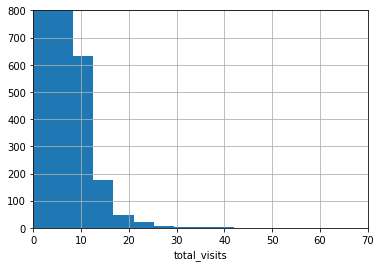

In [40]:
df_spark.select('total_visits').toPandas().total_visits.hist()
plt.xlim(0,70)
plt.ylim(0,800)
plt.xlabel('total_visits')
# Total visits is a right-skewed distribution, hence we take log and square root transformation to make it bell-shaped

Text(0.5,0,'number_emergency')

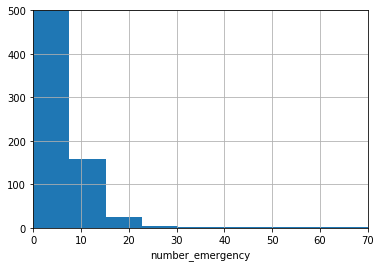

In [41]:
df_spark.select('number_emergency').toPandas().number_emergency.hist()
plt.xlim(0,70)
plt.ylim(0,500)
plt.xlabel('number_emergency')
# number_emergency is a right-skewed distribution, hence we take log and square root transformation to make it bell-shaped

Text(0.5,0,'time_in_hospital')

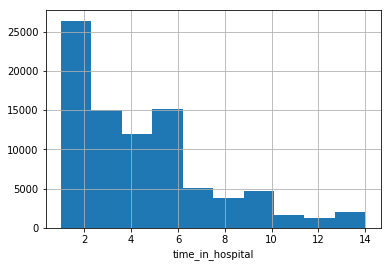

In [42]:
df_spark.select('time_in_hospital').toPandas().time_in_hospital.hist()
plt.xlabel('time_in_hospital')
# Time in hospital is a right-skewed distribution, hence we take log and square root transformation to make it bell-shaped

Text(0.5,0,'num_lab_procedures')

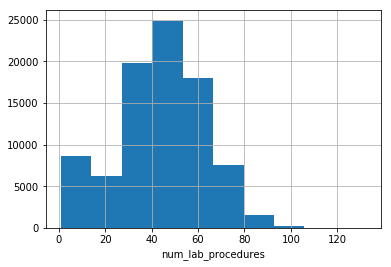

In [43]:
df_spark.select('num_lab_procedures').toPandas().num_lab_procedures.hist()
plt.xlabel('num_lab_procedures')
# num_lab_procedures is a right-skewed distribution, hence we take log and square root transformation to make it bell-shaped

Text(0.5,0,'num_medications')

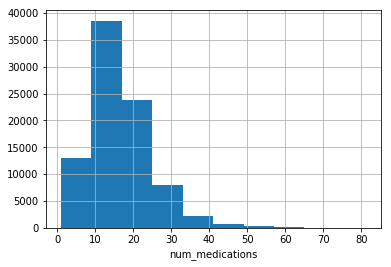

In [44]:
df_spark.select('num_medications').toPandas().num_medications.hist()
plt.xlabel('num_medications')
# num_medications is a right-skewed distribution, hence we take log and square root transformation to make it bell-shaped

Text(0.5,0,'num_procedures')

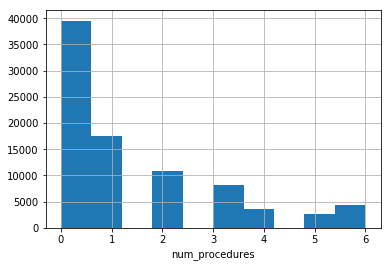

In [45]:
df_spark.select('num_procedures').toPandas().num_procedures.hist()
plt.xlabel('num_procedures')
# num_procedures is a right-skewed distribution, hence we take log and square root transformation to make it bell-shaped

Text(0.5,0,'number_diagnoses')

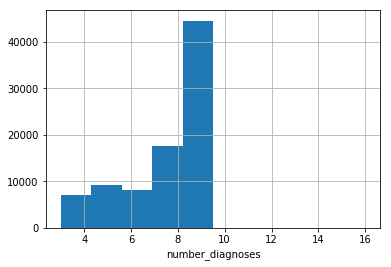

In [46]:
df_spark.select('number_diagnoses').toPandas().number_diagnoses.hist()
plt.xlabel('number_diagnoses')
# This is not a right-skewed and hence we do not take log of this

In [47]:
# Taking sqrt and log transformation both to see which performs better in modeling 

# SQRT Transformation
df_spark = df_spark.withColumn('total_visits_sqrt',fn.round(fn.sqrt(fn.col('total_visits')),2))
df_spark = df_spark.withColumn('number_emergency_sqrt',fn.round(fn.sqrt(fn.col('number_emergency')),2))
df_spark = df_spark.withColumn('num_lab_procedures_sqrt',fn.round(fn.sqrt(fn.col('num_lab_procedures')),2))
df_spark = df_spark.withColumn('num_medications_sqrt',fn.round(fn.sqrt(fn.col('num_medications')),2))

# LOG Transformation - Adding 0.01 as there are many 0 values
df_spark = df_spark.withColumn('total_visits_log',fn.round(fn.log(fn.col('total_visits')+0.01),2))
df_spark = df_spark.withColumn('number_emergency_log',fn.round(fn.log(fn.col('number_emergency')+0.01),2))
df_spark = df_spark.withColumn('num_lab_procedures_log',fn.round(fn.log(fn.col('num_lab_procedures')+0.01),2))
df_spark = df_spark.withColumn('num_medications_log',fn.round(fn.log(fn.col('num_medications')+0.01),2))
df_spark = df_spark.withColumn('time_in_hospital_log',fn.round(fn.log(fn.col('time_in_hospital')+0.01),2))
df_spark = df_spark.withColumn('num_procedures_log',fn.round(fn.log(fn.col('num_procedures')+0.01),2))




In [48]:
# Converting Age into numeric

df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[0-10)',10).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[10-20)',20).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[20-30)',30).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[30-40)',40).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[40-50)',50).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[50-60)',60).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[60-70)',70).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[70-80)',80).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[80-90)',90).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[90-100)',100).otherwise(df_spark.age))
df_spark = df_spark.withColumn('age',fn.when(df_spark.age=='[100-110)',110).otherwise(df_spark.age))


In [49]:
# Changing data type of age into Integer
df_spark = df_spark.withColumn("age", df_spark["age"].cast(IntegerType()))

Text(0.5,0,'age')

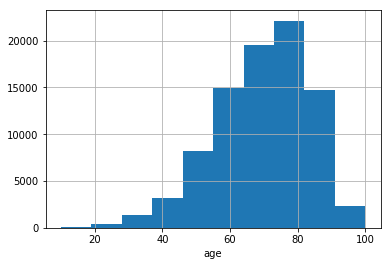

In [50]:
df_spark.select('age').toPandas().age.hist()
plt.xlabel('age')
# Left skewed

## Preparing the data for modeling

## Getting only distinct patients with their first occurence

In [51]:
df_spark.createOrReplaceTempView("temp") 

In [52]:
unique_patient_df = spark.sql("select * from \
          (select patient_nbr, encounter_id,\
          row_number() over (partition by patient_nbr order by encounter_id) as rn \
  from temp \
  ) t \
where rn = 1")

In [53]:
# Converting scientific notation into full numeric number for encounter_id and patient_nbr in unique_patient df
unique_patient_df = unique_patient_df.withColumn('encounter_id', unique_patient_df.encounter_id.cast(DecimalType(15,0)))
unique_patient_df = unique_patient_df.withColumn('patient_nbr', unique_patient_df.patient_nbr.cast(DecimalType(15,0)))
unique_patient_df.select('encounter_id','patient_nbr').show(5)

+------------+-----------+
|encounter_id|patient_nbr|
+------------+-----------+
|    42462216|     113652|
|   100131384|     132318|
|    69445656|     244629|
|    26924070|     300825|
|    36236244|     308619|
+------------+-----------+
only showing top 5 rows

(60735, 3)


In [54]:
# Converting scientific notation into full numeric number for encounter_id and patient_nbr in df_spark df
df_spark = df_spark.withColumn('encounter_id', df_spark.encounter_id.cast(DecimalType(15,0)))
df_spark = df_spark.withColumn('patient_nbr', df_spark.patient_nbr.cast(DecimalType(15,0)))
df_spark.select('encounter_id','patient_nbr').show(10)

+------------+-----------+
|encounter_id|patient_nbr|
+------------+-----------+
|      149190|   55629189|
|       64410|   86047875|
|      500364|   82442376|
|       16680|   42519267|
|       35754|   82637451|
|       55842|   84259809|
|       63768|  114882984|
|       12522|   48330783|
|       15738|   63555939|
|       28236|   89869032|
+------------+-----------+
only showing top 10 rows

(86861, 146)


In [55]:
# Mergint the two datasets to get only distinct patient records (first occurence of their admission in the hospital)
df_spark_final  = df_spark.join(unique_patient_df, on=['encounter_id','patient_nbr'], how='inner')

(60735, 147)


In [56]:
# Taking backup of this df before performing modeling
backup_final = df_spark_final

# PART 2 - Modeling

## Splitting Data into Training, Validation and Testing

In [58]:
training_df,validation_df,testing_df = df_spark_final.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training:  36465
# points in validation:  18232
# points in testing:  6038


In [59]:
# Checking if training_df split has equal proportion of readmitted patients
training_df.groupBy('readmitted').agg(fn.count('readmitted')).show()

+----------+-----------------+
|readmitted|count(readmitted)|
+----------+-----------------+
|         1|            14399|
|         0|            22066|
+----------+-----------------+



## Correlation Testing - To select most significant features for logistic regression

In [64]:
training_df.select( 'dd_home','dd_shortm_hos', 'dd_snf', 'dd_icf','dd_careInst', 'dd_hhs','dd_ama',
 'dd_homeIvy','dd_admInp','dd_expired','dd_hospice','dd_medfac','dd_swingbed','dd_rehab',
 'dd_long','dd_nursing','dd_federal','dd_psy','readmitted').toPandas().corr()
# Only dd_hhs and dd_expired are highly correlated with readmitted

                dd_home  dd_shortm_hos    dd_snf    dd_icf  dd_careInst  \
dd_home        1.000000      -0.187943 -0.474108 -0.118854    -0.148310   
dd_shortm_hos -0.187943       1.000000 -0.052325 -0.013117    -0.016368   
dd_snf        -0.474108      -0.052325  1.000000 -0.033090    -0.041291   
dd_icf        -0.118854      -0.013117 -0.033090  1.000000    -0.010351   
dd_careInst   -0.148310      -0.016368 -0.041291 -0.010351     1.000000   
dd_hhs        -0.472782      -0.052179 -0.131627 -0.032997    -0.041176   
dd_ama        -0.101668      -0.011221 -0.028305 -0.007096    -0.008854   
dd_homeIvy    -0.042148      -0.004652 -0.011734 -0.002942    -0.003671   
dd_admInp     -0.013668      -0.001508 -0.003805 -0.000954    -0.001190   
dd_expired    -0.166773      -0.018406 -0.046431 -0.011640    -0.014525   
dd_hospice    -0.083022      -0.009163 -0.023114 -0.005794    -0.007231   
dd_medfac     -0.063817      -0.007043 -0.017767 -0.004454    -0.005558   
dd_swingbed   -0.029000  

In [65]:
training_df.select( 'admission_source_phyref','admission_source_cliref',
 'admission_source_hmoref','admission_source_hos','admission_source_snf',
 'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
 'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery','readmitted').toPandas().corr()
# Only admission_source_emergency is highly correlated

,admission_source_phyref,admission_source_cliref,admission_source_hmoref,admission_source_hos,admission_source_snf,admission_source_hlthcare,admission_source_emergency,admission_source_court,admission_source_critical,admission_source_normdel,admission_source_birth,admission_source_surgery,readmitted
admission_source_phyref,1.000000,-0.079814,-0.032467,-0.137763,-0.063531,-0.108170,-0.826069,-0.009476,-0.005065,NaN,NaN,-0.003581,-0.026297
admission_source_cliref,-0.079814,1.000000,-0.005541,-0.023510,-0.010842,-0.018460,-0.140971,-0.001617,-0.000864,NaN,NaN,-0.000611,-0.018266
admission_source_hmoref,-0.032467,-0.005541,1.000000,-0.009563,-0.004410,-0.007509,-0.057344,-0.000658,-0.000352,NaN,NaN,-0.000249,0.001919
admission_source_hos,-0.137763,-0.023510,-0.009563,1.000000,-0.018713,-0.031862,-0.243322,-0.002791,-0.001492,NaN,NaN,-0.001055,-0.048833
admission_source_snf,-0.063531,-0.010842,-0.004410,-0.018713,1.000000,-0.014694,-0.112212,-0.001287,-0.000688,NaN,NaN,-0.000486,-0.008040
admission_source_hlthcare,-0.108170,-0.018460,-0.007509,-0.031862,-0.014694,1.000000,-0.191054,-0.002192,-0.001171,NaN,NaN,-0.000828,-0.047058
admission_source_emergency,-0.826069,-0.140971,-0.057344,-0.243322,-0.112212,-0.191054,1.000000,-0.016737,-0.008946,NaN,NaN,-0.006326,0.064934
admission_source_court,-0.009476,-0.001617,-0.000658,-0.002791,-0.001287,-0.002192,-0.016737,1.000000,-0.000103,NaN,NaN,-0.000073,-0.007144
admission_source_critical,-0.005065,-0.000864,-0.000352,-0.001492,-0.000688,-0.001171,-0.008946,-0.000103,1.000000,NaN,NaN,-0.000039,0.001593
admission_source_normdel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
training_df.select('change','diabetesMed','age','readmitted').toPandas().corr()
# DiabetesMed and age are both significantly correlated with readmitted

,change,diabetesMed,age,readmitted
change,1.000000,0.510460,-0.041540,0.042863
diabetesMed,0.510460,1.000000,-0.018258,0.067572
age,-0.041540,-0.018258,1.000000,0.054428
readmitted,0.042863,0.067572,0.054428,1.000000


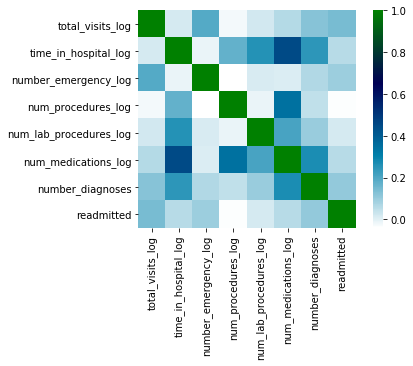

In [68]:
pd_corr = training_df.select('total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
                     'num_lab_procedures_log','num_medications_log','number_diagnoses','readmitted').toPandas()
sns.heatmap(pd_corr.corr(),square=True,cmap='ocean_r')
# All are somewhat correlated with readmitted

In [69]:
training_df.select('repaglinide_index',
 'nateglinide_index',
 'chlorpropamide_index','acetohexamide_index',
 'troglitazone_index',
 'tolazamide_index',
 'glyburide-metformin_index',
 'glipizide-metformin_index',
 'glimepiride-pioglitazone_index',
 'metformin-rosiglitazone_index',
 'metformin-pioglitazone_index',
 'tolbutamide_index',
 'pioglitazone_index','acarbose_index',
 'insulin_index','miglitol_index','readmitted').toPandas().corr()
# Only insulin_index is significantly correlated with readmitted 

,repaglinide_index,nateglinide_index,chlorpropamide_index,acetohexamide_index,troglitazone_index,tolazamide_index,glyburide-metformin_index,glipizide-metformin_index,glimepiride-pioglitazone_index,metformin-rosiglitazone_index,metformin-pioglitazone_index,tolbutamide_index,pioglitazone_index,acarbose_index,insulin_index,miglitol_index,readmitted
repaglinide_index,1.000000,0.001583,-0.003190,-0.000591,-0.000836,-0.002437,-0.005756,-0.001182,NaN,NaN,-0.000591,-0.001447,0.022982,0.027448,0.018487,0.018550,0.018150
nateglinide_index,0.001583,1.000000,-0.002465,-0.000456,-0.000646,-0.001883,-0.004547,-0.000913,NaN,NaN,-0.000456,-0.001118,0.038207,0.000546,0.004171,0.013822,0.007887
chlorpropamide_index,-0.003190,-0.002465,1.000000,-0.000148,-0.000209,-0.000611,-0.002454,-0.000296,NaN,NaN,-0.000148,-0.000363,-0.007702,-0.001432,-0.012726,-0.000513,0.000609
acetohexamide_index,-0.000591,-0.000456,-0.000148,1.000000,-0.000039,-0.000113,-0.000454,-0.000055,NaN,NaN,-0.000027,-0.000067,-0.001427,-0.000265,0.000928,-0.000095,0.006483
troglitazone_index,-0.000836,-0.000646,-0.000209,-0.000039,1.000000,-0.000160,-0.000643,-0.000078,NaN,NaN,-0.000039,-0.000095,-0.002018,-0.000375,0.008786,-0.000134,0.001593
tolazamide_index,-0.002437,-0.001883,-0.000611,-0.000113,-0.000160,1.000000,-0.001874,-0.000226,NaN,NaN,-0.000113,-0.000277,-0.001482,-0.001093,-0.011557,-0.000392,-0.001853
glyburide-metformin_index,-0.005756,-0.004547,-0.002454,-0.000454,-0.000643,-0.001874,1.000000,0.055650,NaN,NaN,-0.000454,-0.001113,0.027668,0.011380,0.010597,-0.001574,-0.001634
glipizide-metformin_index,-0.001182,-0.000913,-0.000296,-0.000055,-0.000078,-0.000226,0.055650,1.000000,NaN,NaN,-0.000055,-0.000134,-0.002853,-0.000530,0.001856,-0.000190,0.002253
glimepiride-pioglitazone_index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
metformin-rosiglitazone_index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
training_df.select('diag1_Circulatory',
 'diag1_Respiratory',
 'diag1_Digestive',
 'diag1_Diabetes',
 'diag1_Injury',
 'diag1_Musculoskeletal',
 'diag1_Genitourinary',
 'diag1_Neoplasms',
 'diag2_Circulatory',
 'diag2_Respiratory',
 'diag2_Digestive',
 'diag2_Diabetes',
 'diag2_Injury',
 'diag2_Musculoskeletal',
 'diag2_Genitourinary',
 'diag2_Neoplasms',
 'diag3_Circulatory',
 'diag3_Respiratory',
 'diag3_Digestive',
 'diag3_Diabetes',
 'diag3_Injury',
 'diag3_Musculoskeletal',
 'diag3_Genitourinary',
 'diag3_Neoplasms','readmitted').toPandas().corr()
# None of the diagnosis is significantly correlated

,diag1_Circulatory,diag1_Respiratory,diag1_Digestive,diag1_Diabetes,diag1_Injury,diag1_Musculoskeletal,diag1_Genitourinary,diag1_Neoplasms,diag2_Circulatory,diag2_Respiratory,...,diag2_Neoplasms,diag3_Circulatory,diag3_Respiratory,diag3_Digestive,diag3_Diabetes,diag3_Injury,diag3_Musculoskeletal,diag3_Genitourinary,diag3_Neoplasms,readmitted
diag1_Circulatory,1.000000,-0.267289,-0.213074,-0.192994,-0.180409,-0.160187,-0.155148,-0.269726,0.310086,0.004083,...,-0.152114,0.172684,0.012987,-0.076862,0.020179,-0.027129,-0.050681,-0.023035,-0.087048,0.026538
diag1_Respiratory,-0.267289,1.000000,-0.127028,-0.115057,-0.107554,-0.095498,-0.092494,-0.160802,-0.005186,0.162598,...,-0.032944,0.016040,0.071775,-0.027054,0.025360,-0.036152,-0.013914,-0.022183,-0.013542,0.017092
diag1_Digestive,-0.213074,-0.127028,1.000000,-0.091719,-0.085739,-0.076128,-0.073734,-0.128186,-0.092842,-0.038709,...,-0.003510,-0.049292,-0.012936,0.162993,0.011750,-0.025347,-0.023675,-0.013752,-0.005330,-0.004855
diag1_Diabetes,-0.192994,-0.115057,-0.091719,1.000000,-0.077659,-0.068954,-0.066785,-0.116106,-0.062210,-0.040673,...,0.188850,-0.052228,-0.027300,0.008741,-0.112353,-0.013384,0.049983,0.008623,0.133628,0.020352
diag1_Injury,-0.180409,-0.107554,-0.085739,-0.077659,1.000000,-0.064457,-0.062430,-0.108535,-0.049642,-0.041749,...,-0.017651,-0.028294,-0.019895,-0.028162,-0.014202,0.129804,0.000604,-0.013237,-0.024867,-0.008161
diag1_Musculoskeletal,-0.160187,-0.095498,-0.076128,-0.068954,-0.064457,1.000000,-0.055432,-0.096369,-0.039834,-0.021318,...,-0.045316,-0.013762,-0.030262,-0.009820,0.053275,0.010697,0.108094,-0.025789,-0.028134,-0.022679
diag1_Genitourinary,-0.155148,-0.092494,-0.073734,-0.066785,-0.062430,-0.055432,1.000000,-0.093338,-0.071331,-0.036371,...,0.087512,-0.038514,-0.019846,-0.011716,-0.015679,-0.009515,-0.007795,0.096310,0.048748,-0.012672
diag1_Neoplasms,-0.269726,-0.160802,-0.128186,-0.116106,-0.108535,-0.096369,-0.093338,1.000000,-0.110072,-0.008054,...,0.089749,-0.065459,0.002132,0.016099,-0.002605,0.021731,-0.004302,0.036968,0.053630,-0.025299
diag2_Circulatory,0.310086,-0.005186,-0.092842,-0.062210,-0.049642,-0.039834,-0.071331,-0.110072,1.000000,-0.230295,...,-0.320131,0.099208,0.018354,-0.072908,0.091997,-0.024385,-0.042292,-0.010258,-0.084353,0.036300
diag2_Respiratory,0.004083,0.162598,-0.038709,-0.040673,-0.041749,-0.021318,-0.036371,-0.008054,-0.230295,1.000000,...,-0.158773,0.016385,0.069320,-0.017855,-0.005158,-0.007144,-0.008282,-0.006171,-0.013534,0.002584


## Trying Different Classification Models

In [71]:
!pip install git+https://github.com/daniel-acuna/pyspark_pipes.git
from pyspark_pipes import pipe

  Cloning https://github.com/daniel-acuna/pyspark_pipes.git to /tmp/pip-rnat5ooh-build
You are using pip version 9.0.3, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Logistic Regression with Cross-Validation and Regularization

In [73]:
numerical_features = pipe(feature.VectorAssembler(inputCols=['time_in_hospital_log','number_emergency_log','total_visits_log',
                                        'num_medications_log','number_diagnoses','age']), feature.StandardScaler())

other_features = feature.VectorAssembler(inputCols=['dd_hhs','dd_expired','diabetesMed','insulin_index','admission_source_emergency'])

all_features = pipe((numerical_features, other_features), feature.VectorAssembler())
  
lr = classification.LogisticRegression(labelCol='readmitted')

final_model_pipeline = pipe(all_features, lr)

paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.1,0.01]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol=lr.getLabelCol(), rawPredictionCol=lr.getRawPredictionCol())
crossval = CrossValidator(estimator=final_model_pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=3)


# Fitting the model on training_df
final_model_fitted = crossval.fit(training_df)

# Checking Validation_df accuracy
evaluator.evaluate(final_model_fitted.transform(validation_df))

0.6351650542883648

In [74]:
# Checking the coefficients
final_model_fitted.bestModel.stages[-1].coefficients

DenseVector([0.0543, 0.1314, 0.2504, 0.0289, 0.14, 0.0869, 0.1044, -21.603, 0.253, 0.0147, 0.2412])

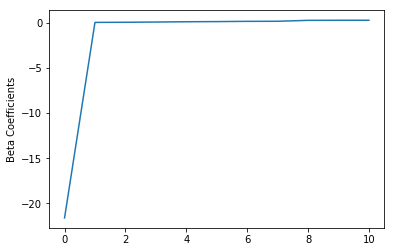

In [75]:
beta = np.sort(final_model_fitted.bestModel.stages[-1].coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [76]:
predictions_logistic = final_model_fitted.bestModel.transform(validation_df)

In [79]:
predictions_logistic = predictions_logistic.withColumn('rawPrediction',fn.col('LogisticRegression_480e82a03674cc091679__rawPrediction'))
predictions_logistic = predictions_logistic.withColumn('label',fn.col('readmitted'))


In [80]:
# Calculating Area under curve
evaluator = BinaryClassificationEvaluator()
print("Validation_df ROC: " + str(evaluator.evaluate(predictions_logistic, {evaluator.metricName: "areaUnderROC"})))

Validation_df ROC: 0.6351650542883652


In [91]:
# Confusion matrix
tp = predictions_logistic[(predictions_logistic.label == 1) & (predictions_logistic.LogisticRegression_480e82a03674cc091679__prediction == 1)].count()
tn = predictions_logistic[(predictions_logistic.label == 0) & (predictions_logistic.LogisticRegression_480e82a03674cc091679__prediction == 0)].count()
fp = predictions_logistic[(predictions_logistic.label == 0) & (predictions_logistic.LogisticRegression_480e82a03674cc091679__prediction == 1)].count()
fn = predictions_logistic[(predictions_logistic.label == 1) & (predictions_logistic.LogisticRegression_480e82a03674cc091679__prediction == 0)].count()

In [92]:
# Printing the confusion matrix
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1779
True Negatives: 9565
False Positives: 1288
False Negatives: 5600


## Random Forest with all features, Cross-Validation and Hyper-parameter tuning

In [93]:
numerical_features = \
    pipe(feature.VectorAssembler(inputCols=['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','age']),\
                            feature.StandardScaler())

other_features= feature.VectorAssembler(inputCols=['admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'
                                        ])

all_features = pipe((numerical_features,other_features), feature.VectorAssembler())

rf = classification.RandomForestClassifier(labelCol='readmitted',numTrees=10)

final_model_pipeline = pipe(all_features, rf)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [100,200]) \
    .addGrid(rf.maxDepth, [4,6]) \
    .build()
crossval = CrossValidator(estimator=final_model_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol=rf.getLabelCol(),rawPredictionCol=rf.getRawPredictionCol()),
                          numFolds=3) 

# Run cross-validation, and choose the best set of parameters.
cvModel_fitted = crossval.fit(training_df)

In [95]:
predictions_rf = cvModel_fitted.transform(validation_df)
# predictions_rf.columns

In [97]:
predictions_rf = predictions_rf.withColumn('rawPrediction',predictions_rf.RandomForestClassifier_4ced90c209d34d9a6abf__rawPrediction)
predictions_rf = predictions_rf.withColumn('label',predictions_rf.readmitted)
evaluator = BinaryClassificationEvaluator()
print("Validation Area Under ROC: " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

Validation Area Under ROC: 0.6458674284007796


In [98]:
# Confusion matrix
tp = predictions_rf[(predictions_rf.label == 1) & (predictions_rf.RandomForestClassifier_4ced90c209d34d9a6abf__prediction == 1)].count()
tn = predictions_rf[(predictions_rf.label == 0) & (predictions_rf.RandomForestClassifier_4ced90c209d34d9a6abf__prediction == 0)].count()
fp = predictions_rf[(predictions_rf.label == 0) & (predictions_rf.RandomForestClassifier_4ced90c209d34d9a6abf__prediction == 1)].count()
fn = predictions_rf[(predictions_rf.label == 1) & (predictions_rf.RandomForestClassifier_4ced90c209d34d9a6abf__prediction == 0)].count()

In [99]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 484
True Negatives: 10604
False Positives: 249
False Negatives: 6895


In [100]:
# Important features by random forest
rf_model = cvModel_fitted.bestModel.stages[-1]
feature_importance=pd.DataFrame(list(zip(['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','age','admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'], rf_model.featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending=False)
feature_importance.head(10)

,feature,importance
0,total_visits_log,0.228255
33,dd_expired,0.132037
6,number_diagnoses,0.108705
2,number_emergency_log,0.101425
5,num_medications_log,0.069953
14,admission_source_emergency,0.037418
7,age,0.034714
1,time_in_hospital_log,0.026046
11,admission_source_hos,0.023276
4,num_lab_procedures_log,0.019616


## Neural Networks with all features and one hidden layer with 8 neurons

In [101]:
# specify layers for the neural network:
# input layer of size 93 (features), one intermediate of size 8
# and output of size 2 (classes)
layers = [93,8,2]

In [103]:
training_df = training_df.withColumn('label',training_df.readmitted)

va = feature.VectorAssembler(inputCols=['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery','age',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'
                                        ], outputCol='features')


# create the trainer and set its parameters
neural = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

pipeline = Pipeline(stages=[va, neural])
model_neural = pipeline.fit(training_df)


In [104]:
# Compute accuracy on the validation set
result_neural = model_neural.transform(validation_df)
result_neural = result_neural.withColumn('label',result_neural.readmitted)
predictionAndLabels = result_neural.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Validation set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Validation set accuracy = 0.6182536200087758


In [105]:
# Confusion matrix
tp = result_neural[(result_neural.label == 1) & (result_neural.prediction == 1)].count()
tn = result_neural[(result_neural.label == 0) & (result_neural.prediction == 0)].count()
fp = result_neural[(result_neural.label == 0) & (result_neural.prediction == 1)].count()
fn = result_neural[(result_neural.label == 1) & (result_neural.prediction == 0)].count()


In [106]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1232
True Negatives: 10040
False Positives: 813
False Negatives: 6147


## Gradient Boosting with Cross-validation and Hyper-parameter tuning

In [107]:
numerical_features = \
    pipe(feature.VectorAssembler(inputCols=['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','age']),\
                            feature.StandardScaler())

other_features= feature.VectorAssembler(inputCols=['admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'])

all_features = pipe((numerical_features,other_features), feature.VectorAssembler())

gbt = GBTClassifier(labelCol='readmitted')

final_model_pipeline = pipe(all_features, gbt)

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [4, 6]) \
    .addGrid(gbt.maxBins, [20, 40]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .build()

evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=final_model_pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)



In [108]:
cvModel_gbt = cv.fit(training_df)

In [109]:
predictions_gbt2 = cvModel_gbt.transform(validation_df)

In [110]:
predictions_gbt2 = predictions_gbt2.withColumn('label',predictions_gbt2.readmitted)

In [111]:
evaluator.evaluate(predictions_gbt2)

0.6488827202769503

In [113]:
# Confusion matrix
tp = predictions_gbt2[(predictions_gbt2.label == 1) & (predictions_gbt2.GBTClassifier_4a66b2bd6c632910703d__prediction == 1)].count()
tn = predictions_gbt2[(predictions_gbt2.label == 0) & (predictions_gbt2.GBTClassifier_4a66b2bd6c632910703d__prediction == 0)].count()
fp = predictions_gbt2[(predictions_gbt2.label == 0) & (predictions_gbt2.GBTClassifier_4a66b2bd6c632910703d__prediction == 1)].count()
fn = predictions_gbt2[(predictions_gbt2.label == 1) & (predictions_gbt2.GBTClassifier_4a66b2bd6c632910703d__prediction == 0)].count()


In [114]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 2070
True Negatives: 9410
False Positives: 1443
False Negatives: 5309


In [115]:
# Important features by gradient boosting
gbt_model = cvModel_gbt.bestModel.stages[-1]
feature_importance=pd.DataFrame(list(zip(['total_visits_log','time_in_hospital_log','number_emergency_log','num_procedures_log',
'num_lab_procedures_log','num_medications_log','number_diagnoses','age','admission_source_phyref','admission_source_cliref',
'admission_source_hmoref','admission_source_hos','admission_source_snf',
'admission_source_hlthcare','admission_source_emergency', 'admission_source_court', 'admission_source_critical',
'admission_source_normdel', 'admission_source_birth', 'admission_source_surgery',
'dd_home','dd_shortm_hos','dd_snf','AfricanAmerican','Asian','Caucasian','Hispanic','dd_icf',
'dd_careInst','dd_hhs','dd_ama','dd_homeIvy','dd_admInp','dd_expired','dd_hospice',
'dd_medfac','dd_swingbed','dd_rehab','dd_long','dd_nursing','dd_federal','dd_psy','diag1_Circulatory',
'diag1_Respiratory','diag1_Digestive','diag1_Diabetes',
'diag1_Injury','diag1_Musculoskeletal','diag1_Genitourinary','diag1_Neoplasms',
'diag2_Circulatory','diag2_Respiratory','diag2_Digestive','diag2_Diabetes','diag2_Injury','diag2_Musculoskeletal',
'diag2_Genitourinary','diag2_Neoplasms','diag3_Circulatory','diag3_Respiratory','diag3_Digestive',
'diag3_Diabetes','diag3_Injury','diag3_Musculoskeletal','diag3_Genitourinary','diag3_Neoplasms',
'max_glu_200','max_glu_300','max_glu_norm','A1Cresult_7','A1Cresult_8','A1Cresult_norm',
'metformin_index','repaglinide_index','nateglinide_index','chlorpropamide_index','glimepiride_index',
'acetohexamide_index','troglitazone_index','tolazamide_index','glyburide-metformin_index',
'glipizide-metformin_index','glimepiride-pioglitazone_index','metformin-rosiglitazone_index',
'metformin-pioglitazone_index','glipizide_index','glyburide_index','tolbutamide_index','pioglitazone_index',
'rosiglitazone_index','acarbose_index','insulin_index','miglitol_index'], gbt_model.featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending=False)
feature_importance.head(10)

,feature,importance
33,dd_expired,0.095722
7,age,0.081390
5,num_medications_log,0.065826
0,total_visits_log,0.055073
1,time_in_hospital_log,0.052958
34,dd_hospice,0.045259
35,dd_medfac,0.040594
3,num_procedures_log,0.039675
2,number_emergency_log,0.038940
91,insulin_index,0.038005


## Model Comparision based on Accuracy and False Negatives

Text(0.5,1,'Model Comparison based on Accuracy')

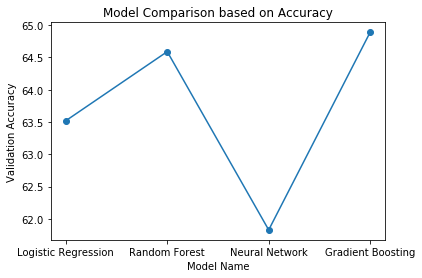

In [119]:
# As this is a health care domain, we compare our models based on False Negatives and accuracy.
# The model with the least FN and highest accuracy is the best model in our case.

model_comparison_df = pd.DataFrame({'Model_name': ['Logistic Regression', 'Random Forest',
                                                 'Neural Network','Gradient Boosting'],
                                   'Validation_Accuracy': [63.52, 64.59,61.83,64.89],
                                   'False_Negatives': [5600,6895,6147,5309]})

plt.plot(model_comparison_df.Model_name,model_comparison_df.Validation_Accuracy,'-o')
plt.xlabel('Model Name')
plt.ylabel('Validation Accuracy')
plt.title('Model Comparison based on Accuracy')

Text(0.5,1,'Model Comparison based on False Negatives')

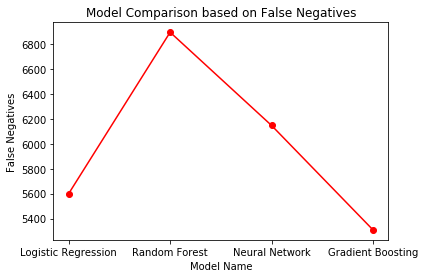

In [121]:
plt.plot(model_comparison_df.Model_name,model_comparison_df.False_Negatives,'-or')
plt.xlabel('Model Name')
plt.ylabel('False Negatives')
plt.title('Model Comparison based on False Negatives')

## We can clearly see from the above graphs that Gradient Boosting has the maximum accuracy on Validation set and least False Negatives

## Testing Gradient Boosting on test dataset

In [125]:
predictions_gbt2_test = cvModel_gbt.transform(testing_df)
predictions_gbt2_test = predictions_gbt2_test.withColumn('prediction',predictions_gbt2_test.GBTClassifier_4a66b2bd6c632910703d__prediction)

predictions_gbt2_test = predictions_gbt2_test.withColumn('label',predictions_gbt2_test.readmitted)
evaluator.evaluate(predictions_gbt2_test)

0.642649087266837

In [126]:
# Confusion matrix
tp = predictions_gbt2_test[(predictions_gbt2_test.label == 1) & (predictions_gbt2_test.GBTClassifier_4a66b2bd6c632910703d__prediction == 1)].count()
tn = predictions_gbt2_test[(predictions_gbt2_test.label == 0) & (predictions_gbt2_test.GBTClassifier_4a66b2bd6c632910703d__prediction == 0)].count()
fp = predictions_gbt2_test[(predictions_gbt2_test.label == 0) & (predictions_gbt2_test.GBTClassifier_4a66b2bd6c632910703d__prediction == 1)].count()
fn = predictions_gbt2_test[(predictions_gbt2_test.label == 1) & (predictions_gbt2_test.GBTClassifier_4a66b2bd6c632910703d__prediction == 0)].count()


In [127]:
print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 682
True Negatives: 3084
False Positives: 513
False Negatives: 1759


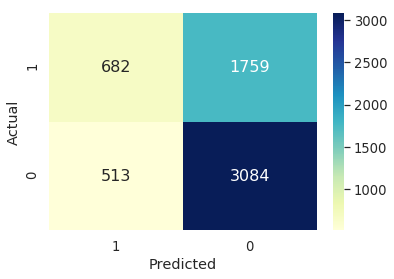

In [128]:
# Plotting the test set confusion matrix
array = [[3084,513],
     [1759,682]]        
df_cm = pd.DataFrame(array, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap='YlGnBu',fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

In [129]:
# True-positive rate, False-positive rate and AUC
x = 3084/(1759+3084)
y = 682/(682+513)

AUC = (3084/(2*(1759+3084))) + (682/(2*(682+513)))


print("TP:",x)
print("FP:",y)
print("AUC:",AUC)

TP: 0.636795374767706
FP: 0.5707112970711297
AUC: 0.6037533359194178


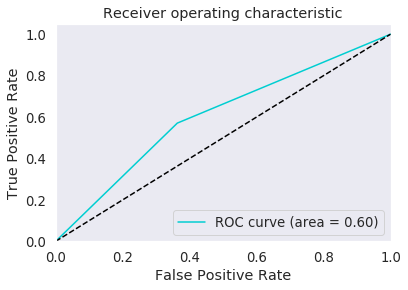

In [131]:
# Plotting the test set ROC and AUC
predictions_gbt2_test_df = predictions_gbt2_test.toPandas()
predictions_test = predictions_gbt2_test_df['prediction']
outcome_test = predictions_gbt2_test_df['label']
fpr, tpr, thresholds = roc_curve(predictions_test, outcome_test)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkturquoise', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid(b=False)
plt.show()

## Inference and Results

In [132]:
# As total number of visits and emergency visits increases, the chances of getting re-admitted increases
# With increasing number of diagnoses and medications, the patient has a higher chance of getting re-admitted
# As people get older,they have a higher chance of re-admission
# A patient who stays for a longer duration in hospital has a higher chance of re-admission
# A patient who has discharge dispositon id as hospice or medfac has a higher chance of getting re-admitted

## Conclusion

In [133]:
# Gradient Boosting performed the best in terms of accuracy and number of false negatives
# and also fits the testing data well